In [83]:
import numpy as np
import librosa as lb
import IPython.display as ipd
import matplotlib.pyplot as plt

import k3d
from k3d.colormaps import matplotlib_color_maps

import skimage
import import_ipynb
import align_tools
import matplotlib.pyplot as plt
from hmc_mir import tsm_tools

In [73]:
def normalize_features(part_cqt):
    part_cqt_with_noise = part_cqt + np.abs(np.random.randn(*part_cqt.shape)) * 1e-8
    part_cqt_norm = part_cqt_with_noise / np.linalg.norm(part_cqt_with_noise, axis=0)

    mask = np.where(part_cqt_norm < np.max(part_cqt_norm) * 0.05)
    part_cqt_norm[mask] = 0

    return part_cqt_norm

In [74]:
hop_size = 512
o_file = f'../o.wav'
po_file = f'../po.wav'
p_file = f'../p_0.80.wav'

time_start = 0 # seconds
time_end = 15 # seconds

In [75]:
n_bins = 36

y_o, sr = lb.load(o_file, sr=22050)
y_o = y_o[time_start*sr:time_end*sr]
F_o = lb.feature.chroma_cqt(y=y_o, sr=sr, hop_length=hop_size)
# F_o = lb.feature.chroma_cens(y=y_o, sr=sr, hop_length=hop_size)
# F_o = lb.feature.chroma_vqt(y=y_o, sr=sr, intervals='ji5', bins_per_octave=n_bins)

y_po, sr = lb.load(po_file, sr=22050)
y_po = y_po[time_start*sr:time_end*sr]
F_po = lb.feature.chroma_cqt(y=y_po, sr=sr, hop_length=hop_size)
# F_po = lb.feature.chroma_cens(y=y_po, sr=sr, hop_length=hop_size)
# F_po = lb.feature.chroma_vqt(y=y_po, sr=sr, intervals='ji5', bins_per_octave=n_bins)

y_p, sr = lb.load(p_file, sr=22050)
y_p = y_p[time_start*sr:time_end*sr]
F_p = lb.feature.chroma_cqt(y=y_p, sr=sr, hop_length=hop_size)
# F_p = lb.feature.chroma_cens(y=y_p, sr=sr, hop_length=hop_size)
# F_p = lb.feature.chroma_vqt(y=y_p, sr=sr, intervals='ji5', bins_per_octave=n_bins)

F_o = normalize_features(F_o)
F_po = normalize_features(F_po)
F_p = normalize_features(F_p)

In [76]:
# Manually align O to PO (this makes things worse in practice)
# wp = align_tools.compute_dtw_alignment(F_po.T @ F_o, np.array([1,1,1,2,2,1]).reshape((-1,2)), np.array([2,3,3])) * (hop_size / sr)
# downsample = 20
# wp_middle = wp[:,1:-1] # keep ends, downsample the middle
# wp = np.hstack((wp[:,0].reshape((2,-1)), wp_middle[:,0::downsample], wp[:,-1].reshape((2,-1))))
# y_o_aligned = tsm_tools.tsmvar_hybrid(y_o, np.flipud(wp))
# F_o = lb.feature.chroma_cqt(y=y_o_aligned, sr=sr, hop_length=hop_size)
# F_o = normalize_features(F_o)

# while F_o.shape[1] < F_p.shape[1]:
#     F_o = np.hstack((F_o, F_o[:,-1].reshape((-1,1))))

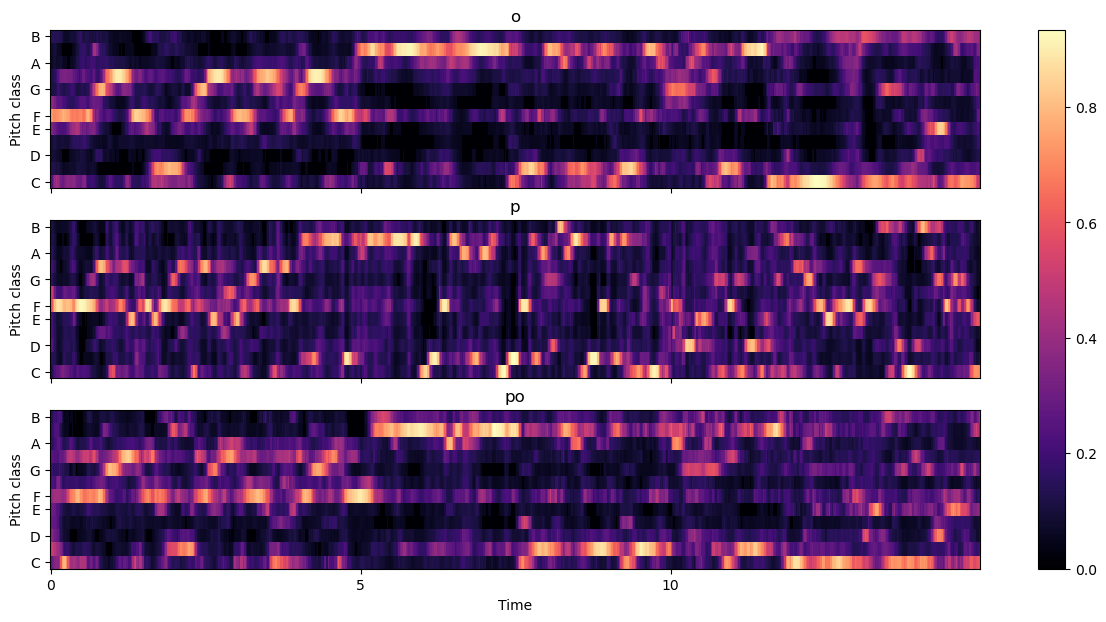

In [77]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(15, 7))
lb.display.specshow(F_o, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='o')
ax[0].label_outer()
img = lb.display.specshow(F_p, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='p')
ax[1].label_outer()
img = lb.display.specshow(F_po, y_axis='chroma', x_axis='time', ax=ax[2])
ax[2].set(title='po')
fig.colorbar(img, ax=ax)
plt.show()

(12, 646)


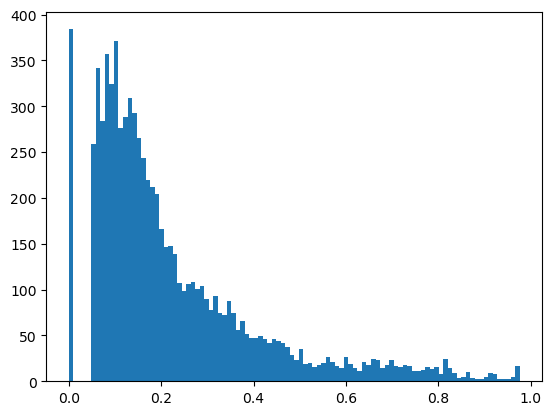

In [53]:
print(F_o.shape)
plt.hist(F_o.flatten(), bins=100)
plt.show()

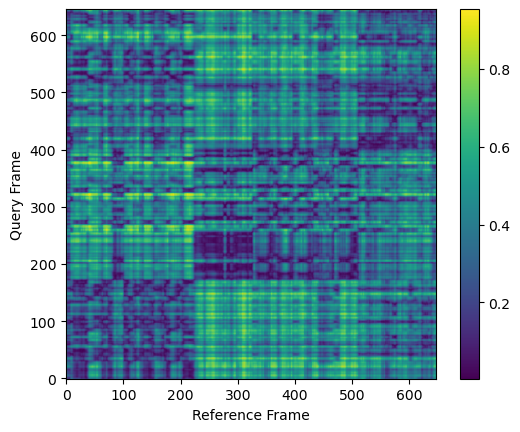

In [54]:
C = 1 - F_p.T @ F_po
plt.imshow(C, origin = 'lower')
plt.xlabel('Reference Frame')
plt.ylabel('Query Frame')
plt.colorbar()
plt.show()

In [55]:
C_2d = F_p.T @ F_po

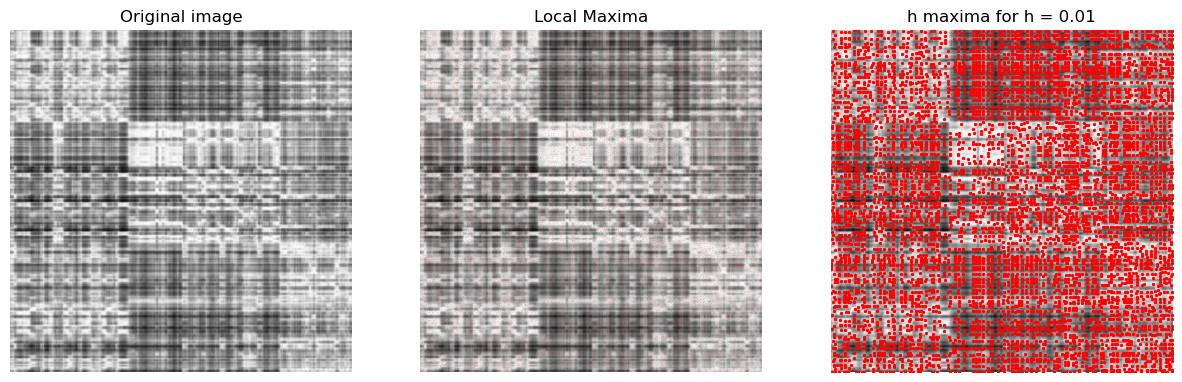

In [56]:
# image = C_2d.reshape((C_2d.shape[0], C_2d.shape[1], 1))
image = C_2d
# image = 2.*(C_2d - np.min(C_2d))/np.ptp(C_2d)-1

from skimage.feature import hog
from skimage import data, exposure
from skimage.morphology import reconstruction
from scipy.cluster.vq import kmeans2
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage.util.shape import view_as_windows
from skimage.util import montage
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt
from skimage import data, filters
from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure

import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

img = exposure.rescale_intensity(image)

local_maxima = extrema.local_maxima(img)
label_maxima = label(local_maxima)
overlay = color.label2rgb(label_maxima, img, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])

h = 0.01
h_maxima = extrema.h_maxima(img, h)
# label_h_maxima = label(h_maxima)
# overlay_h = color.label2rgb(label_h_maxima, img, alpha=1, bg_label=0,
                            # bg_color=None, colors=[(1, 0, 0)])
points = []
for i in range(h_maxima.shape[0]):
    for j in range(h_maxima.shape[1]):
        if h_maxima[i,j] > 0:
            points.append([i,j])

# a new figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(overlay)
ax[1].set_title('Local Maxima')
ax[1].axis('off')

ax[2].imshow(img, cmap='gray')
ax[2].scatter(np.array(points)[:,1], np.array(points)[:,0], c='r', s=2)
ax[2].set_title(f'h maxima for h = {h:.2f}')
ax[2].axis('off')
plt.show()

In [57]:
# C = np.einsum('dx,dy,dz->xyz', F_o, F_p, F_po)

In [58]:
# C.shape

In [59]:
# plt_volume = k3d.volume(C)

# plot = k3d.plot()
# plot += plt_volume
# plot.display()

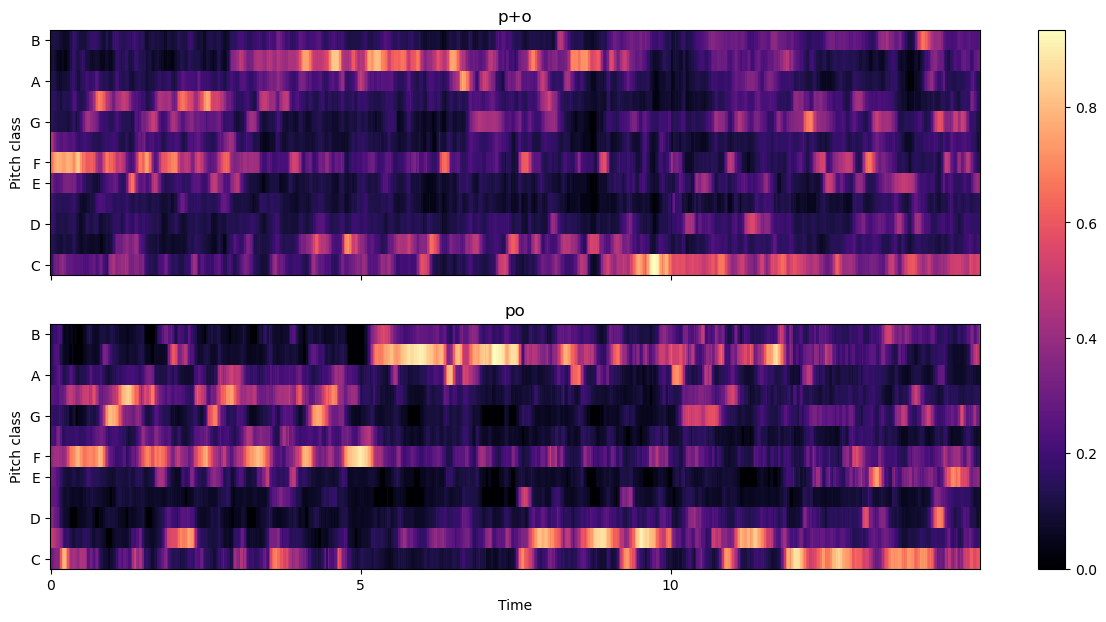

In [60]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15, 7))
lb.display.specshow(F_o+F_p, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='p+o')
ax[0].label_outer()
img = lb.display.specshow(F_po, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='po')
fig.colorbar(img, ax=ax)
plt.show()

In [61]:
p_index = 0
po_index = 0
o_index = 0

path = []

steps = [
    [1, 1, 1],
    [1, 1, 2],
    [1, 2, 1],
    [2, 1, 1],
    [1, 2, 2],
    [2, 1, 2],
    [2, 2, 1],
]

weights = [
    1,
    2,
    2,
    2,
    4,
    4,
    4,
]

while (p_index < F_p.shape[1]) and (po_index < F_po.shape[1]) and (o_index < F_o.shape[1]):
    min_cost = np.inf
    min_step = None

    for step in steps:
        p_index_new = p_index + step[0]
        po_index_new = po_index + step[1]
        o_index_new = o_index + step[2]

        if (p_index_new >= F_p.shape[1]) or (po_index_new >= F_po.shape[1]) or (o_index_new >= F_o.shape[1]):
            continue

        cost = np.sum(weights[steps.index(step)] * (F_po[:, po_index_new] - (F_p[:, p_index_new] + F_o[:, o_index_new])))

        if cost < min_cost:
            min_cost = cost
            min_step = step

    if min_step is None:
        break
    
    p_index += min_step[0]
    po_index += min_step[1]
    o_index += min_step[2]

    path.append([p_index, po_index, o_index])

path = np.array(path)

In [63]:

plt_line = k3d.line(path, width=0.1, color=0xff99cc)

plot = k3d.plot()
plot += plt_line
plot.display()

Output()

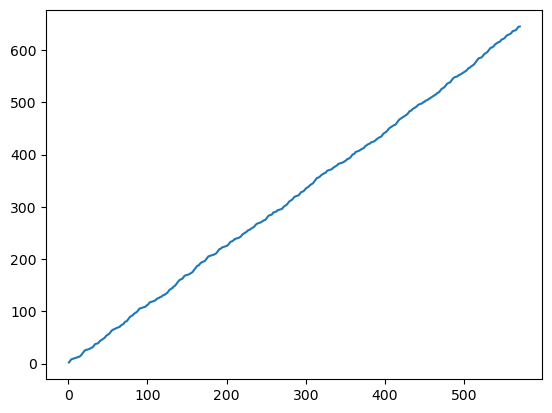

In [64]:
# plt.scatter(path[:,0], path[:,2])
# plt.plot(align_tools.infer_alignment(path[:,0], path[:,2], True))
wp_AC = np.vstack((path[:,0], path[:,2])).T
plt.plot(wp_AC[:,0], wp_AC[:,1])

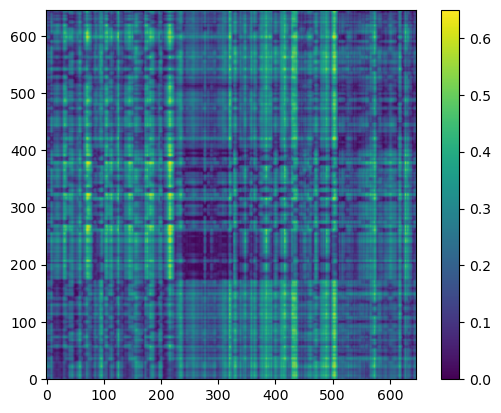

In [92]:
custom_cost = np.zeros((F_p.shape[1], F_o.shape[1]))

for i in range(F_p.shape[1]):
    for j in range(F_o.shape[1]):
        custom_cost[i,j] = np.dot(F_po[:, j], (F_p[:, i] + F_o[:, j])) / (np.linalg.norm(F_po[:, i]) + np.linalg.norm(F_p[:, i] + F_o[:, j]))
        # custom_cost[i,j] = np.linalg.norm(F_po[:, j] - (F_p[:, i] + F_o[:, j]))

custom_cost = 1-custom_cost/np.max(custom_cost)
# custom-cost = custom_cost/np.max(custom_cost)

plt.imshow(custom_cost, origin = 'lower')
plt.colorbar()
plt.show()

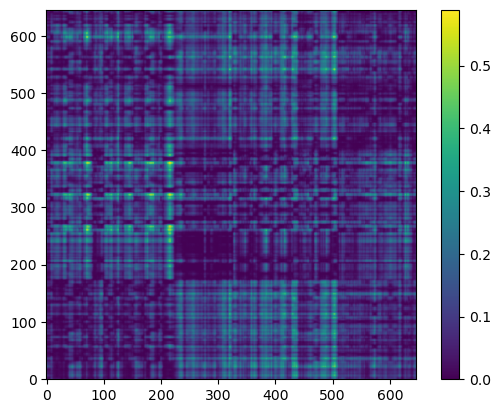

In [106]:
custom_cost = C*custom_cost
plt.imshow(custom_cost, origin = 'lower')
plt.colorbar()
plt.show()

In [107]:
plt_surface = k3d.surface(custom_cost,
                        #   color=0x006394,
                        #   wireframe=True,
                          xmin=0, xmax=5,
                          ymin=0, ymax=5,
                          color_map=matplotlib_color_maps.Coolwarm_r,
                          attribute=custom_cost)

plot = k3d.plot()
plot += plt_surface
plot.display()

/home/kdey/ttmp/micromamba/envs/PianoConcertoAccompaniment/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

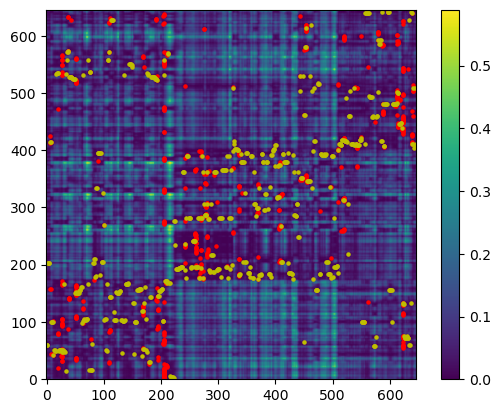

In [108]:
plt.imshow(custom_cost, origin = 'lower')
plt.colorbar()
plt.scatter(np.argmin(custom_cost, axis=1), np.arange(custom_cost.shape[0]), label='argmin', s=5, c='r')
plt.scatter(np.arange(custom_cost.shape[0]), np.argmin(custom_cost, axis=0), label='argmin', s=5, c='y')
plt.show()

In [67]:
p_index = 0
o_index = 0

path = []

steps = [
    [1, 1, 2],
    [1, 2, 1],
    [2, 1, 1],
]

while (p_index < F_p.shape[1]) and (o_index < F_o.shape[1]):
    min_cost = np.inf
    min_step = None

    for step in steps:
        p_index_new = p_index + step[0]
        o_index_new = o_index + step[1]

        if (p_index_new >= F_p.shape[1]) or (o_index_new >= F_o.shape[1]):
            continue

        cost = custom_cost[p_index_new, o_index_new] * step[2]

        if cost < min_cost:
            min_cost = cost
            min_step = step

    if min_step is None:
        break

    p_index += min_step[0]
    o_index += min_step[1]

    path.append([p_index, o_index])

path = np.array(path)

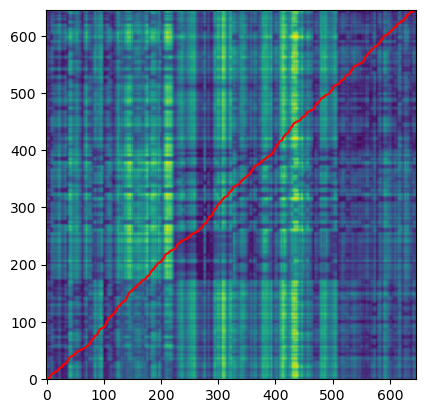

In [68]:
plt.plot(path[:,1], path[:,0], color='r')
plt.imshow(custom_cost, origin = 'lower')
plt.show()

In [69]:
loc = np.array([0.0, 0.0])
last_step = np.array([0.0, 0.0])

path = []

max_slope = 3

gamma = 0.5


while (loc[0] < F_p.shape[1]) and (loc[1] < F_o.shape[1]):
    min_cost = np.inf
    min_step = None

    for i in range(-max_slope, max_slope+1):
        if i != 0 and i != -1:
            if i < 0:
                step = np.array([-i, 1])
            else:
                step = np.array([1, i])

            step = (1-gamma) * last_step + gamma * step

            loc_new = [loc[0] + step[0], loc[1] + step[1]]

            if (loc_new[0] >= F_p.shape[1]) or (loc_new[1] >= F_o.shape[1]):
                continue

            cost = custom_cost[int(loc_new[0]), np.int(loc_new[1])] * ((1+max_slope) - np.abs(i))

            if cost < min_cost:
                min_cost = cost
                min_step = step.copy()
            
    if min_step is None:
        break

    loc += min_step

    path.append(loc.tolist())
    last_step = min_step

path = np.array(path)

/tmp/ipykernel_279918/3883807159.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cost = custom_cost[int(loc_new[0]), np.int(loc_new[1])] * ((1+max_slope) - np.abs(i))


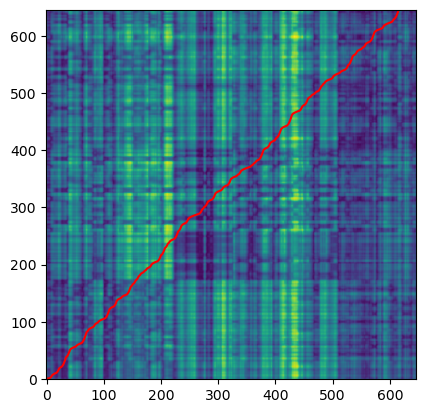

In [70]:
plt.plot(path[:,1], path[:,0], color='r')
plt.imshow(custom_cost, origin = 'lower')
plt.show()

In [71]:
loc = np.array([0.0, 0.0])
last_step = np.array([0.0, 0.0])

path = []

band_width = 5
max_slope = 3
gamma = 0.5

paths = np.array([0,0])

while (loc[0] < F_p.shape[1]) and (loc[1] < F_o.shape[1]):
    min_cost = np.inf
    min_step = None

    for i in range(-max_slope, max_slope+1):
        if i != 0 and i != -1:
            if i < 0:
                step = np.array([-i, 1])
            else:
                step = np.array([1, i])

            step = (1-gamma) * last_step + gamma * step

            loc_new = [loc[0] + step[0], loc[1] + step[1]]

            if (loc_new[0] >= F_p.shape[1]) or (loc_new[1] >= F_o.shape[1]):
                continue

            cost = custom_cost[int(loc_new[0]), np.int(loc_new[1])] * ((1+max_slope) - np.abs(i))

            if cost < min_cost:
                min_cost = cost
                min_step = step.copy()
            
    if min_step is None:
        break

    loc += min_step

    path.append(loc.tolist())
    last_step = min_step

path = np.array(path)

/tmp/ipykernel_279918/543476140.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cost = custom_cost[int(loc_new[0]), np.int(loc_new[1])] * ((1+max_slope) - np.abs(i))
